# Early Stopping Case Study

Early stopping is so easy to use, e.g. with the simplest trigger, that there is little reason to not
use it when training neural networks. Use of early stopping may be a staple of the modern
training of deep neural networks.

**Early stopping should be used almost universally.**
    — Page 425, Deep Learning, 2016



In [64]:
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model



import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Binary Classification Problem

Use a standard binary classification problem that defines two semi-circles of observations,
one semi-circle for each class. Each observation has two input variables with the same scale and
a class output value of either 0 or 1. This dataset is called the moons dataset because of the
shape of the observations in each class when plotted. We can use the make moons() function to
generate observations from this problem. We will add noise to the data and seed the random
number generator so that the same samples are generated each time the code is run.
- Problem 1. Blobs problem with two input variables and three classes with the random state
    argument set to one.
- Problem 2. Blobs problem with two input variables and three classes with the random state
    argument set to two 


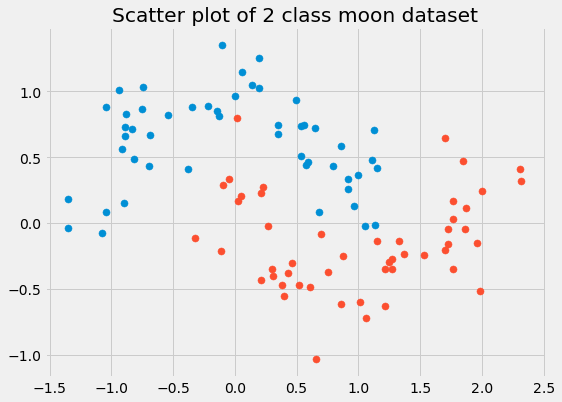

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

#make 2D classification dataset
X,y = make_moons(n_samples=100,noise=0.2,random_state=1)

for class_value in range(2):
    #select indices of points with class label
    row_ix = np.where(y == class_value)
    #scatter for points with different colour
    plt.scatter(X[row_ix,0],X[row_ix,1],s=50)
plt.title('Scatter plot of 2 class moon dataset')
plt.show()


Classes cannot be separated by a straight line, e.g.
are not linearly separable, requiring a nonlinear method such as a neural network to address. We
have only generated 100 samples, which is small for a neural network, providing the opportunity
to overfit the training dataset and have higher error on the test dataset: a good case for using
regularization. Further, the samples have noise, giving the model an opportunity to learn aspects
of the samples that don’t generalize.

### Overfit Multilayer Perceptron
Overfit a MLP model.  Generate and split the data  

In [48]:
seed = 1
X,y = make_moons(n_samples=100,noise=0.2,random_state=seed)

#overfit
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.7)

In [49]:
#define model
model = Sequential()
model.add(Dense(500,input_dim=2,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [50]:
#fit
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=4000,verbose=0)

In [51]:
#evaluate
_,train_acc = model.evaluate(X_train,y_train,verbose=0)
_,test_acc = model.evaluate(X_test,y_test,verbose=0)
print("Train: {:.3f} Test: {:.3f}".format(train_acc,test_acc))

Train: 1.000 Test: 0.943


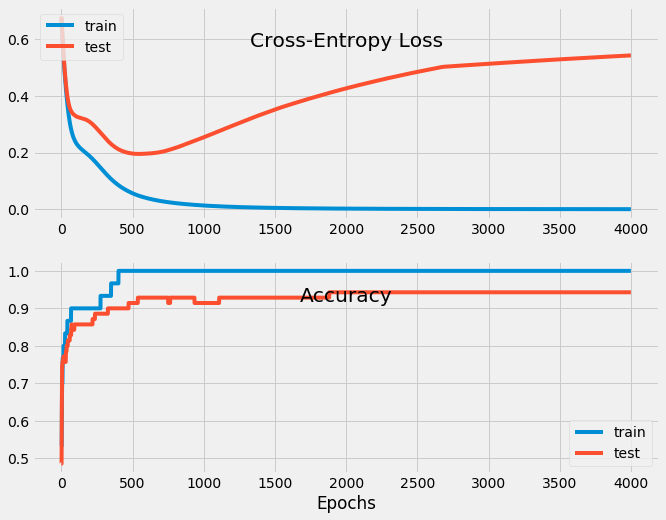

In [52]:
#plot
rcParams['figure.figsize'] = 10, 8

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(loc=2)
#plt.title('Train and Test Datasets While Training Showing an OverfitModel')

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.xlabel('Epochs')
plt.show()


Plots show an overfit model where test accuracy increases to a
point and then begins to decrease again. Also see flat spots in
the ups and downs in the validation loss. Any early stopping will have to account for these
behaviors. We would also expect that a good time to stop training might be around epoch 800.

### Overfit MLP With Early Stopping

As soon as the loss of the
model begins to increase on the test dataset, we will stop training. First, we can define the
EarlyStopping callback.  Then update the call to fit() and specify a lost of callbacks via the callback argument

In [56]:
#simple early stopping
es = EarlyStopping(monitor = 'val_loss',mode='min',verbose=1)
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4000, verbose=0,callbacks=[es])


Epoch 00002: early stopping


Epoch 00156: early stopping
Train: 0.967 Test: 0.800


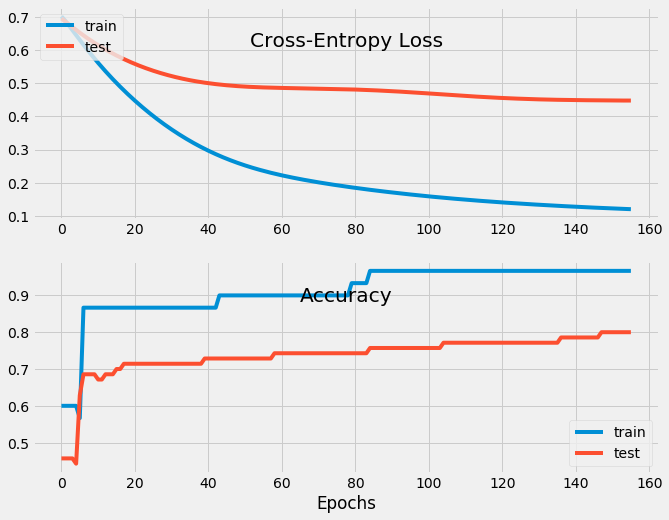

In [61]:
seed = 1
X,y = make_moons(n_samples=100,noise=0.2,random_state=seed)

#overfit
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.7)

#define model
model = Sequential()
model.add(Dense(500,input_dim=2,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

#simple early stopping
es = EarlyStopping(monitor = 'val_loss',mode='min',verbose=1)
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4000, verbose=0,callbacks=[es])

#evaluate
_,train_acc = model.evaluate(X_train,y_train,verbose=0)
_,test_acc = model.evaluate(X_test,y_test,verbose=0)
print("Train: {:.3f} Test: {:.3f}".format(train_acc,test_acc))

#plot
rcParams['figure.figsize'] = 10, 8

# plot loss learning curves
plt.subplot(211)
plt.title('Cross-Entropy Loss', pad=-40)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(loc=2)
#plt.title('Train and Test Datasets While Training Showing an OverfitModel')

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.xlabel('Epochs')
plt.show()

Callback stopped training at epoch 156 - too early as we
would expect an early stop to be around epoch 800. This is also highlighted by the classification
accuracy on both the train and test sets, which is worse than no early stopping.


Use accuracy on the validation in the ModelCheckpoint callback to save the best model
observed during training.

In [82]:
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1,save_best_only=True)

In [81]:
seed = 1
X,y = make_moons(n_samples=100,noise=0.2,random_state=seed)

#overfit
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.7)

#define model
model = Sequential()
model.add(Dense(500,input_dim=2,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=0,save_best_only=True)

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4000, verbose=0,callbacks=[es,mc])

# load the saved model
saved_model = load_model('best_model.h5')

#evaluate
_,train_acc = model.evaluate(X_train,y_train,verbose=0)
_,test_acc = model.evaluate(X_test,y_test,verbose=0)
print("Train: {:.3f} Test: {:.3f}".format(train_acc,test_acc))

print("Early stopping at epoch number:{}".format(history.epoch[-1]))

Train: 1.000 Test: 0.929
Early stopping at epoch number:810


Best model at epoch 810